# Foreword

The intention of this project is providing a thorough analysis of a dataset regarding it-related job offerings, where we analyse relevant aspects such as the job title, location and gross average salary. 

Due to time constraints, and the technical difficulties encountered in previous web scraping attempts, it has been withdrawn the option to scrap data from infojobs, since the general T&C of the website do not allow for web scrapping, plus, they have controls in place to block any web scrapping action. 

We insted take the data from a .csv dataset obtained from kaggle, whose link is provided in the initial section. 

1. the project consists of an analysis of IT industry job openings from a kaggle datasets that has a sample size of 3,755 elements
2. we provide information on the gross salary, irrespective of other benefits (contributions to pensions schema, health insurance, travel allowances, etc.)
3. we do not take into account the inflation effect / consumer price index (6,1% in the Eurozone as of June 2023) 
4. this dataset provides information as of April 2023 

Sources: digitalocean.com, kaggle, datacamp, geeks for geeks, eurostat, medium.com, towardsdatascience.com, educative.io, appsloveworld, datatechnotes

# Dataset 

# 1. Read the data

Data source: https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023

In [66]:
import pandas as pd                   
import numpy as np   

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OneHotEncoder

from sklearn.neighbors import KNeighborsRegressor

We will call 'init_dataset' to the original dataset that we have obtained from kaggle

In [33]:
init_dataset = pd.read_csv('ds_salaries (1).csv')
init_dataset.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


With the following transformation we convert remote_ratios to unit values (0, 0.5, 1)

We will drop the variable 'work year', 'salary currency' and 'employee residence'

These variables will be essential though for data visualisation that we will perform with tableau 

On the other hand, we already have in the dataset the salary expressed in usd, which is a way to compare gross salaries across different locations worldwide where they have different currencies

We think that 'company location' might have a more direct impact on the 'salary' variable; 

New dataset looks like this: 

In [34]:
columns_to_drop = ['work_year', 'salary', 'salary_currency', 'employee_residence']
dataset = init_dataset.drop(columns=columns_to_drop)

In [35]:
dataset.head()

,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size
0,SE,FT,Principal Data Scientist,85847,100,ES,L
1,MI,CT,ML Engineer,30000,100,US,S
2,MI,CT,ML Engineer,25500,100,US,S
3,SE,FT,Data Scientist,175000,100,CA,M
4,SE,FT,Data Scientist,120000,100,CA,M


In [36]:
print(dataset['experience_level'].unique())

['SE' 'MI' 'EN' 'EX']


In [37]:
print(dataset['employment_type'].unique())

['FT' 'CT' 'FL' 'PT']


In [38]:
print(dataset['job_title'].unique())

['Principal Data Scientist' 'ML Engineer' 'Data Scientist'
 'Applied Scientist' 'Data Analyst' 'Data Modeler' 'Research Engineer'
 'Analytics Engineer' 'Business Intelligence Engineer'
 'Machine Learning Engineer' 'Data Strategist' 'Data Engineer'
 'Computer Vision Engineer' 'Data Quality Analyst'
 'Compliance Data Analyst' 'Data Architect'
 'Applied Machine Learning Engineer' 'AI Developer' 'Research Scientist'
 'Data Analytics Manager' 'Business Data Analyst' 'Applied Data Scientist'
 'Staff Data Analyst' 'ETL Engineer' 'Data DevOps Engineer' 'Head of Data'
 'Data Science Manager' 'Data Manager' 'Machine Learning Researcher'
 'Big Data Engineer' 'Data Specialist' 'Lead Data Analyst'
 'BI Data Engineer' 'Director of Data Science'
 'Machine Learning Scientist' 'MLOps Engineer' 'AI Scientist'
 'Autonomous Vehicle Technician' 'Applied Machine Learning Scientist'
 'Lead Data Scientist' 'Cloud Database Engineer' 'Financial Data Analyst'
 'Data Infrastructure Engineer' 'Software Data Engine

In [39]:
dataset['job_title'].nunique()

93

In [40]:
print(dataset['remote_ratio'].unique())

[100   0  50]


In [41]:
print(dataset['company_location'].unique())

['ES' 'US' 'CA' 'DE' 'GB' 'NG' 'IN' 'HK' 'NL' 'CH' 'CF' 'FR' 'FI' 'UA'
 'IE' 'IL' 'GH' 'CO' 'SG' 'AU' 'SE' 'SI' 'MX' 'BR' 'PT' 'RU' 'TH' 'HR'
 'VN' 'EE' 'AM' 'BA' 'KE' 'GR' 'MK' 'LV' 'RO' 'PK' 'IT' 'MA' 'PL' 'AL'
 'AR' 'LT' 'AS' 'CR' 'IR' 'BS' 'HU' 'AT' 'SK' 'CZ' 'TR' 'PR' 'DK' 'BO'
 'PH' 'BE' 'ID' 'EG' 'AE' 'LU' 'MY' 'HN' 'JP' 'DZ' 'IQ' 'CN' 'NZ' 'CL'
 'MD' 'MT']


In [42]:
dataset['company_location'].nunique()

72

Some previous considerations regarding some variables: 

1. work_year might be treated as a categorical variable; it might be also helpful in order to provide the plot for the categoricals

2. remote_ration indicates the proportion of the time (in %) that the work is performed remotely

3. it might be interesting to find as well some outliers, in particular, when dealing with large vs. small companies, experience level entry level vs. management position 

# 2. Exploratory data analysis 

We provide sns countplots to get an idea of hoe certain values are distributed in the dataset, including work year, experience level, employment type and company size, however, this information will be analysed in more detail with Tableau data visualisation 

In [43]:
dataset.shape

(3755, 7)

In [44]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   experience_level  3755 non-null   object
 1   employment_type   3755 non-null   object
 2   job_title         3755 non-null   object
 3   salary_in_usd     3755 non-null   int64 
 4   remote_ratio      3755 non-null   int64 
 5   company_location  3755 non-null   object
 6   company_size      3755 non-null   object
dtypes: int64(2), object(5)
memory usage: 205.5+ KB


In [45]:
print(dataset.isnull().sum())

experience_level    0
employment_type     0
job_title           0
salary_in_usd       0
remote_ratio        0
company_location    0
company_size        0
dtype: int64


We have a dataset with 3,755 elements and none of them are null 

# Get num and cat variables 

In [46]:
num = dataset.select_dtypes(include=np.number)
num

,salary_in_usd,remote_ratio
0,85847,100
1,30000,100
2,25500,100
3,175000,100
4,120000,100
...,...,...
3750,412000,100
3751,151000,100
3752,105000,100
3753,100000,100


In [47]:
cat = dataset.select_dtypes(include=np.object)
cat

C:\Users\ruizg\AppData\Local\Temp\ipykernel_28240\1892227502.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat = dataset.select_dtypes(include=np.object)


,experience_level,employment_type,job_title,company_location,company_size
0,SE,FT,Principal Data Scientist,ES,L
1,MI,CT,ML Engineer,US,S
2,MI,CT,ML Engineer,US,S
3,SE,FT,Data Scientist,CA,M
4,SE,FT,Data Scientist,CA,M
...,...,...,...,...,...
3750,SE,FT,Data Scientist,US,L
3751,MI,FT,Principal Data Scientist,US,L
3752,EN,FT,Data Scientist,US,S
3753,EN,CT,Business Data Analyst,US,L


# Descriptive statistics 

In [48]:
dataset.describe()

,salary_in_usd,remote_ratio
count,3755.000000,3755.000000
mean,137570.389880,46.271638
std,63055.625278,48.589050
min,5132.000000,0.000000
25%,95000.000000,0.000000
50%,135000.000000,0.000000
75%,175000.000000,100.000000
max,450000.000000,100.000000


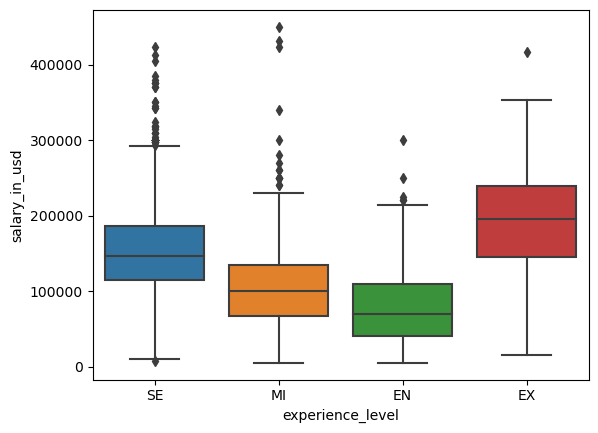

In [49]:
ax = sns.boxplot(x="experience_level", y="salary_in_usd", data=dataset)
plt.show()

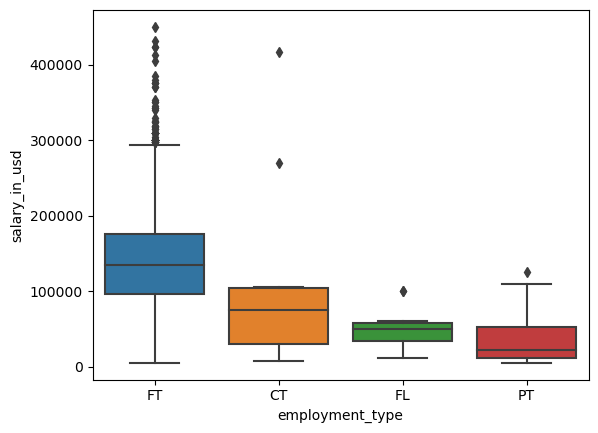

In [50]:
ax = sns.boxplot(x="employment_type", y="salary_in_usd", data=dataset)
plt.show()

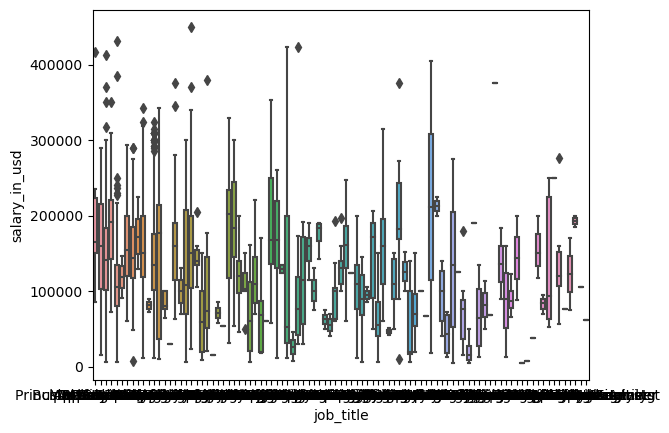

In [51]:
ax = sns.boxplot(x="job_title", y="salary_in_usd", data=dataset)
plt.show()

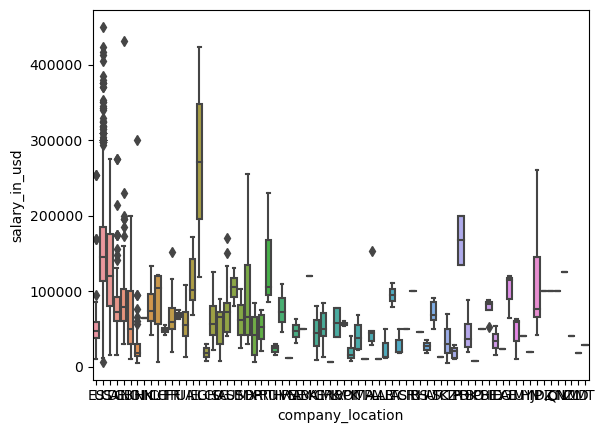

In [52]:
ax = sns.boxplot(x="company_location", y="salary_in_usd", data=dataset)
plt.show()

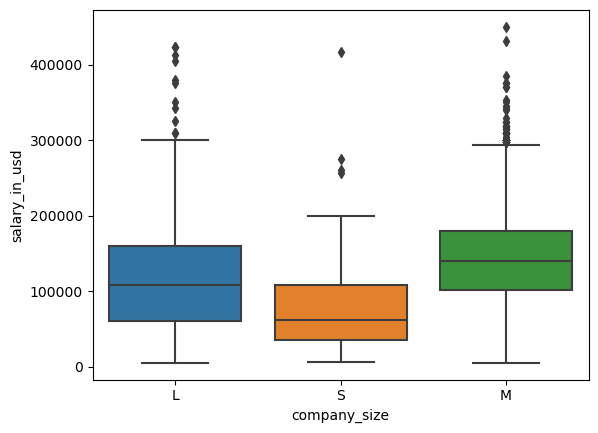

In [53]:
ax = sns.boxplot(x="company_size", y="salary_in_usd", data=dataset)
plt.show()

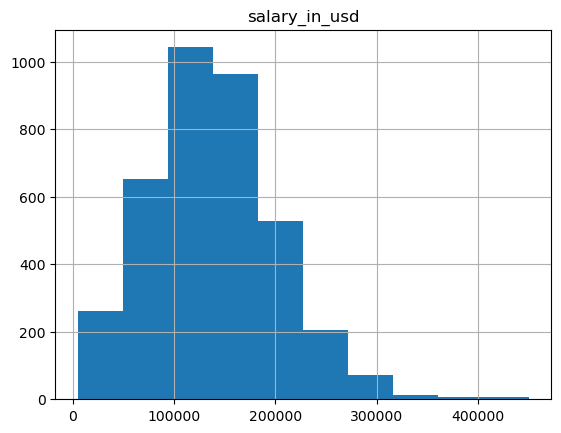

In [54]:
dataset.hist(column='salary_in_usd');

C:\Users\ruizg\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


AttributeError: 'AxesSubplot' object has no attribute 'unique'

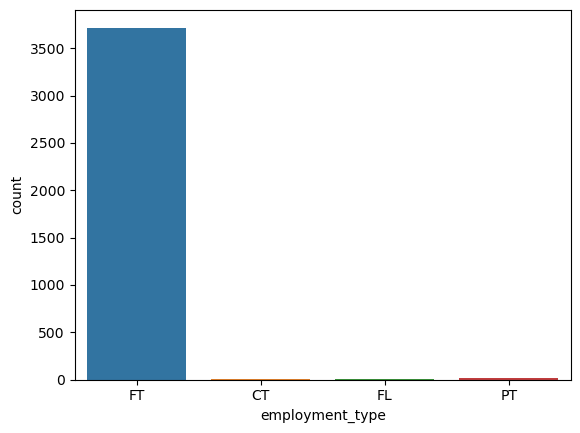

In [55]:
sns.countplot(dataset['employment_type']).unique()

In [ ]:
sns.countplot(dataset['company_size']).unique()

We see that 'medium' companies account for the majority of employers in the dataset, we might find some outliers from large and small companies

In [ ]:
average_salary = dataset.groupby(['company_size', 'experience_level'])['salary_in_usd'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=dataset, x='company_size', y='salary_in_usd', hue='experience_level', ci=None)
plt.xlabel('Company Size')
plt.ylabel('Average Salary in USD')
plt.title('Average Salary by Company Size and Experience Level')
plt.legend(title='Experience Level')
plt.show()

In [ ]:
sns.pairplot(
    dataset,
    plot_kws=dict(marker="+", linewidth=1),
    diag_kws=dict(fill=False),
)

In [ ]:
dataset.corr()

In [ ]:
sns.heatmap(dataset.corr());

# Machine learning

1. Initial machine learning model 

In [67]:
X = dataset[['experience_level', 'employment_type', 'remote_ratio', 'company_size', 'company_location']]
y = dataset['salary_in_usd']

X_encoded = pd.get_dummies(X, columns=['experience_level', 'employment_type', 'company_size', 'company_location'])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [68]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R^2):", r2)

Mean Absolute Error (MAE): 42973770819.71571
Mean Squared Error (MSE): 3.4677846012106515e+23
Root Mean Squared Error (RMSE): 588878985973.4045
R-squared (R^2): -87841165456152.3


# Machine learning: min-max scaler

In [69]:
X = dataset[['experience_level', 'employment_type', 'remote_ratio', 'company_size', 'company_location']]
y = dataset['salary_in_usd']


X_encoded = pd.get_dummies(X, columns=['experience_level', 'employment_type', 'company_size', 'company_location'])


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# We apply min-max scaler to the remote ratio, which is the only numerical value in the predictor variables dataset: 

scaler = MinMaxScaler()
X_train[['remote_ratio']] = scaler.fit_transform(X_train[['remote_ratio']])
X_test[['remote_ratio']] = scaler.transform(X_test[['remote_ratio']])

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [70]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R^2):", r2)

Mean Absolute Error (MAE): 186198752216038.4
Mean Squared Error (MSE): 6.720325495301718e+30
Root Mean Squared Error (RMSE): 2592359059872246.5
R-squared (R^2): -1.7023007240585654e+21


# Normalisation 

We apply normalisation to our machine learning model. Note that 'remote_ratio' is the only numerical predictor variable, the rest, are treated as categoricals. 

In [71]:
X = dataset[['remote_ratio']]
y = dataset['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [72]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R^2):", r2)

Mean Absolute Error (MAE): 48755.29718507113
Mean Squared Error (MSE): 3920216393.684486
Root Mean Squared Error (RMSE): 62611.63145681868
R-squared (R^2): 0.006984526255339074


# Model performance issues

Some steps that we could take to improve the overall performance of the model include:
1. Hyperparam. tunning
2. Cross-valitation 

# Hyperparameter tuning

In [73]:
target = 'salary_in_usd'
predictors = ['experience_level', 'employment_type', 'job_title', 'remote_ratio', 'company_size']

X = dataset[predictors]
y = dataset[target]

X = pd.get_dummies(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

hyperparameters = {
    'alpha': [0.1, 1.0, 10.0],  
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag']  
}

model = Ridge()

grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

best_hyperparameters = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_val)

In [74]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R^2):", r2)

Mean Absolute Error (MAE): 42371.22005588524
Mean Squared Error (MSE): 2959553698.7127604
Root Mean Squared Error (RMSE): 54401.780289920294
R-squared (R^2): 0.250326430210692


# Cross validation 

In [75]:
target = 'salary_in_usd'
predictors = ['experience_level', 'employment_type', 'job_title', 'remote_ratio', 'company_size']

X = dataset[predictors]
y = dataset[target]

X = pd.get_dummies(X)

model = LinearRegression()

cv_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)

mse_scores = -cv_scores

mean_mse = mse_scores.mean()
std_mse = mse_scores.std()

print("Mean MSE:", mean_mse)
print("Standard Deviation of MSE:", std_mse)

Mean MSE: 4.670334228625226e+26
Standard Deviation of MSE: 7.760211408125329e+26


In [76]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R^2):", r2)

Mean Absolute Error (MAE): 42371.22005588524
Mean Squared Error (MSE): 2959553698.7127604
Root Mean Squared Error (RMSE): 54401.780289920294
R-squared (R^2): 0.250326430210692


# k-nearest - regression model 

In [102]:
X = dataset[['experience_level', 'employment_type', 'remote_ratio', 'company_size', 'company_location']]
y = dataset['salary_in_usd']

X_encoded = pd.get_dummies(X, columns=['experience_level', 'employment_type', 'company_size', 'company_location'])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

k = 5  # Number of neighbors to consider
model = KNeighborsRegressor(n_neighbors=k)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [103]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R^2):", r2)

Mean Absolute Error (MAE): 45150.02210386152
Mean Squared Error (MSE): 3397034025.2302
Root Mean Squared Error (RMSE): 58284.08037560685
R-squared (R^2): 0.139509911410723


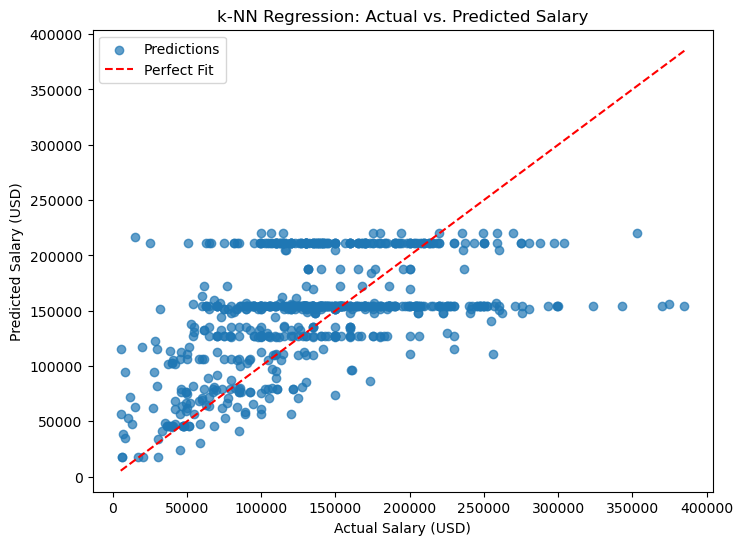

In [104]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Fit')
plt.xlabel('Actual Salary (USD)')
plt.ylabel('Predicted Salary (USD)')
plt.title('k-NN Regression: Actual vs. Predicted Salary')
plt.legend()
plt.show()

In [105]:
residuals = y_test - y_pred

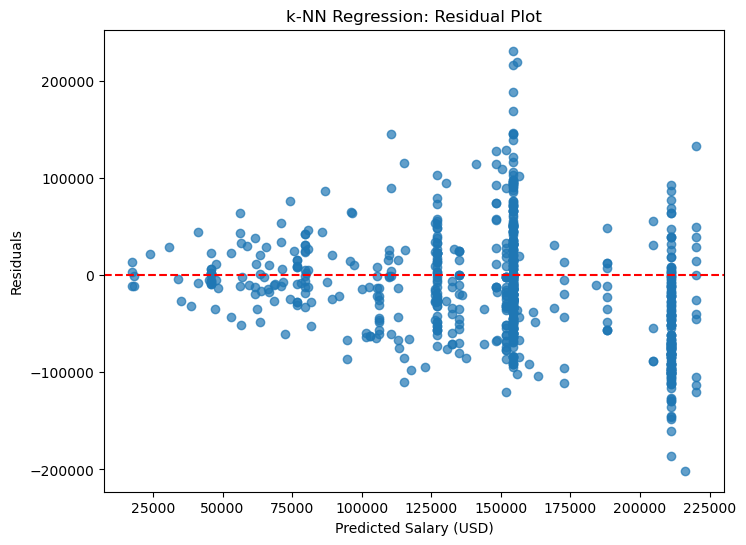

In [106]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Salary (USD)')
plt.ylabel('Residuals')
plt.title('k-NN Regression: Residual Plot')
plt.show()

Coming steps:

1. hypothesis testing / anova
2. streamlit application deployment 

# Hypothesis testing 

perform a hypothesis testing where we assume that the average salary for an entry level job (experience_level = 'EN') is at least (higher than or equal to) 30.000 (salary_in_usd)

perform a hypothesis testing where we assume that there is no significant difference between the average salary for an senior and middle management position ('SE', 'ME')

# Anova 

Based on the initial dataset, we want to find if there has been any significant difference in the avg. salary for the years 2021, 2022 and 2023

# Streamlit application deployment

And finally, here comes the best part of the project!! 

In simple words, we are going to deploy a Streamlit user interface where we select the values for the input variables of our model ('experience_level','employment_type','job_title', 'remote_ratio', and 'company_size') and the user eventually gets an estimate of the average salary (expressed in usd, irrespective of the job location) on how much he is going to get paid on average. Note that this is just an estimate which does not consider other aspects from the package benetis, such as travel allowance, insurance, overtime payment, etc. 

In [92]:
X = dataset[['experience_level', 'employment_type', 'job_title', 'remote_ratio', 'company_size']]
y = dataset['salary_in_usd']
model = LinearRegression()
model.fit(X, y)

def main():
    st.title("Salary Estimator")
    
    experience_level = st.selectbox("Select Experience Level", ['SE' 'MI' 'EN' 'EX'])
    employment_type = st.selectbox("Select Employment Type", ['FT' 'CT' 'FL' 'PT'])
    job_title = st.text_input("Enter Job Title", "")
    remote_ratio = st.slider("Remote Work Ratio (%)", min_value=0, max_value=100, value=50, step=1)
    company_size = st.slider("Company Size", min_value=1, max_value=10000, value=100, step=1)

    user_input = pd.DataFrame({
        'experience_level': [experience_level],
        'employment_type': [employment_type],
        'job_title': [job_title],
        'remote_ratio': [remote_ratio],
        'company_size': [company_size]
    })    

    predicted_salary = model.predict(user_input)[0]
    
    st.write(f"Estimated Average Salary: ${predicted_salary:.2f}")

if __name__ == '__main__':
    main()

ValueError: could not convert string to float: 'SE'